[*********************100%***********************]  5 of 5 completed
C:\Users\leojn\PycharmProjects\fiap-tech-challenge-2\.venv\Lib\site-packages\pygad\pygad.py:753: UserWarning: The percentage of genes to mutate (mutation_percent_genes=15) resulted in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any gene, please set mutation_type=None.
  warnings.warn(f"The percentage of genes to mutate (mutation_percent_genes={mutation_percent_genes}) resulted in selecting ({mutation_num_genes}) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).\nIf you do not want to mutate any gene, please set mutation_type=None.")


Dados coletados com sucesso. Período: 30/06/2020 até 27/06/2025
Geração 10: Melhor Sharpe Ratio = 0.9065
Geração 20: Melhor Sharpe Ratio = 0.9070
Geração 30: Melhor Sharpe Ratio = 0.9076
Geração 40: Melhor Sharpe Ratio = 0.9077

Carteira Otimizada:
      Ativo   Peso
0  PETR4.SA  0.002
1  VALE3.SA  0.009
2  ITUB4.SA  0.080
3  BBDC4.SA  0.908
4  ABEV3.SA  0.002

Sharpe Ratio: 0.9077


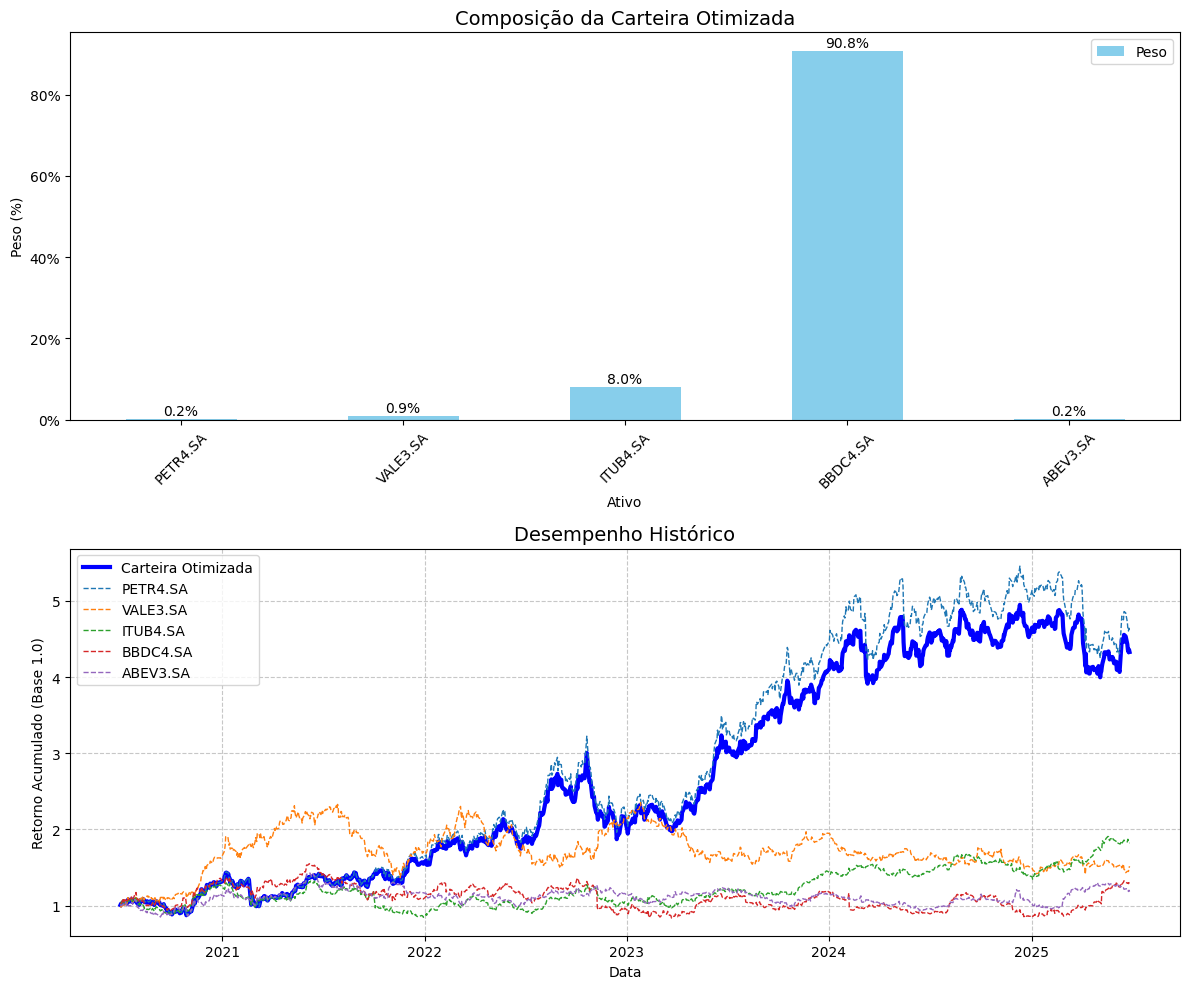


Estatísticas da Carteira Otimizada:
Retorno Anual Esperado: 35.41%
Risco Anual (Volatilidade): 33.50%
Sharpe Ratio: 0.9077

Matriz de Correlação entre os Ativos:
Ticker    ABEV3.SA  BBDC4.SA  ITUB4.SA  PETR4.SA  VALE3.SA
Ticker                                                    
ABEV3.SA      1.00      0.42      0.45      0.26      0.11
BBDC4.SA      0.42      1.00      0.73      0.37      0.22
ITUB4.SA      0.45      0.73      1.00      0.39      0.23
PETR4.SA      0.26      0.37      0.39      1.00      0.28
VALE3.SA      0.11      0.22      0.23      0.28      1.00


In [8]:
# 🧰 Instale as bibliotecas antes de rodar:
# pip install yfinance pandas numpy PyGAD matplotlib

# 📝 Melhorias implementadas:
# 1. Coleta de dados:
#    - Atualização da data final para garantir disponibilidade de dados
#    - Adição de tratamento de erros para download de dados
#    - Verificação de dados vazios
#
# 2. Função de fitness:
#    - Normalização de pesos para soma = 1
#    - Tratamento de casos com risco zero ou muito baixo
#    - Inclusão de taxa livre de risco no cálculo do Sharpe Ratio
#    - Atualização da assinatura da função para compatibilidade com PyGAD 2.20.0+
#
# 3. Restrições e normalização:
#    - Tratamento para casos onde todos os pesos são zero
#    - Geração de pesos aleatórios quando necessário
#    - Monitoramento do progresso a cada 10 gerações
#
# 4. Algoritmo Genético:
#    - Aumento do tamanho da população e número de gerações
#    - Configuração de parâmetros de mutação e crossover
#    - Adição de critérios de parada
#
# 5. Visualização e análise:
#    - Gráfico de composição da carteira otimizada
#    - Gráfico de desempenho histórico comparativo
#    - Estatísticas detalhadas da carteira
#    - Matriz de correlação entre ativos

import yfinance as yf
import numpy as np
import pandas as pd
import pygad
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# 🎯 Lista de ativos brasileiros
tickers = ['PETR4.SA', 'VALE3.SA', 'ITUB4.SA', 'BBDC4.SA', 'ABEV3.SA']

# 🗃️ Coleta dos dados de fechamento
try:
    # Usando uma data final no passado para garantir disponibilidade de dados
    dados = yf.download(tickers, start="2020-06-30", end="2025-06-30", auto_adjust=False)
    if dados.empty:
        raise ValueError("Não foi possível obter dados para os tickers especificados")
    # Usando a coluna 'Adj Close' para os cálculos
    dados_adj = dados['Adj Close']
    retornos = dados_adj.pct_change().dropna()
    media_anuais = retornos.mean() * 252
    risco_anuais = retornos.std() * np.sqrt(252)
    print(f"Dados coletados com sucesso. Período: {dados.index[0].strftime('%d/%m/%Y')} até {dados.index[-1].strftime('%d/%m/%Y')}")
except Exception as e:
    print(f"Erro ao coletar dados: {e}")
    raise

# 🧬 Função de fitness para o AG
def fitness_func(ga_instance, solution, solution_idx):
    pesos = np.array(solution)
    if np.sum(pesos) == 0:
        return 0
    pesos = pesos / np.sum(pesos)
    retorno = np.dot(pesos, media_anuais)
    risco = np.sqrt(np.dot(pesos.T, np.dot(retornos.cov() * 252, pesos)))
    if risco < 0.0001:
        return 0
    taxa_livre_risco = 0.05
    sharpe = (retorno - taxa_livre_risco) / risco
    return sharpe

# 📐 Restrições: soma dos pesos deve ser 1
def on_gen(ga_instance):
    for i in range(ga_instance.sol_per_pop):
        soma = np.sum(ga_instance.population[i])
        if soma == 0:
            # Se todos os pesos forem zero, gerar pesos aleatórios
            ga_instance.population[i] = np.random.random(len(tickers))
            soma = np.sum(ga_instance.population[i])

        # Normalizar para que a soma seja 1
        ga_instance.population[i] /= soma

    # Imprimir informações sobre a melhor solução a cada 10 gerações
    if ga_instance.generations_completed % 10 == 0:
        best_solution = ga_instance.best_solution()[0]
        best_fitness = ga_instance.best_solution()[1]
        print(f"Geração {ga_instance.generations_completed}: Melhor Sharpe Ratio = {best_fitness:.4f}")

# 🔁 Configuração do AG
ga_instance = pygad.GA(
    num_generations=150,           # Aumentado para melhor convergência
    num_parents_mating=10,         # Aumentado para maior diversidade
    fitness_func=fitness_func,
    sol_per_pop=50,                # População maior para explorar mais soluções
    num_genes=len(tickers),
    gene_type=float,
    gene_space={'low': 0, 'high': 1},
    mutation_type="random",        # Tipo de mutação
    mutation_percent_genes=15,     # Percentual de genes que sofrem mutação
    keep_parents=2,                # Manter os melhores pais na próxima geração
    crossover_type="uniform",      # Tipo de crossover
    on_generation=on_gen,
    stop_criteria=["reach_150", "saturate_10"]  # Critérios de parada
)

# 🚀 Execução do AG
ga_instance.run()

# 💡 Resultado ótimo
solucao, fitness, _ = ga_instance.best_solution()
pesos_otimizados = np.round(solucao / np.sum(solucao), 3)
carteira_final = pd.DataFrame({
    'Ativo': tickers,
    'Peso': pesos_otimizados
})

print("\nCarteira Otimizada:")
print(carteira_final)
print(f"\nSharpe Ratio: {round(fitness, 4)}")

# 📊 Visualização dos resultados
plt.figure(figsize=(12, 10))

# Gráfico de barras para os pesos da carteira
plt.subplot(2, 1, 1)
ax = carteira_final.plot(kind='bar', x='Ativo', y='Peso', color='skyblue', ax=plt.gca())
plt.title('Composição da Carteira Otimizada', fontsize=14)
plt.ylabel('Peso (%)')
plt.xlabel('Ativo')
plt.xticks(rotation=45)
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
for i, v in enumerate(pesos_otimizados):
    plt.text(i, v + 0.01, f'{v:.1%}', ha='center')

# Gráfico de desempenho histórico
plt.subplot(2, 1, 2)
# Calcular o desempenho da carteira otimizada
desempenho_carteira = (retornos * pesos_otimizados).sum(axis=1)
desempenho_acumulado = (1 + desempenho_carteira).cumprod()
# Calcular desempenho de cada ativo individualmente para comparação
desempenho_ativos = (1 + retornos).cumprod()

# Plotar desempenho da carteira otimizada
plt.plot(desempenho_acumulado.index, desempenho_acumulado, 'b-', linewidth=3, label='Carteira Otimizada')

# Plotar desempenho de cada ativo
for i, ticker in enumerate(tickers):
    plt.plot(desempenho_ativos.index, desempenho_ativos[ticker], '--', linewidth=1, label=ticker)

plt.title('Desempenho Histórico', fontsize=14)
plt.ylabel('Retorno Acumulado (Base 1.0)')
plt.xlabel('Data')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()

# 📈 Estatísticas da carteira otimizada
retorno_anual = np.dot(pesos_otimizados, media_anuais)
risco_anual = np.sqrt(np.dot(pesos_otimizados.T, np.dot(retornos.cov() * 252, pesos_otimizados)))

print("\nEstatísticas da Carteira Otimizada:")
print(f"Retorno Anual Esperado: {retorno_anual:.2%}")
print(f"Risco Anual (Volatilidade): {risco_anual:.2%}")
print(f"Sharpe Ratio: {fitness:.4f}")

# Correlação entre os ativos
print("\nMatriz de Correlação entre os Ativos:")
correlacao = retornos.corr()
print(correlacao.round(2))